## Lasso & Ridge regression

In [5]:
# Import necessary package 
import pandas as pd
import numpy as np
import seaborn as sn
import tensorflow as tf
import pymc3 as pm
from scipy import optimize
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import arviz as az
import tensorflow as tf
import theano
import altair as alt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
import sys

import datetime as dt
#imcport pandas_datareader.data as web
import requests
from bs4 import BeautifulSoup
import textwrap

# For model fit
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.cm as mplcm

# for reproducable results
import random


from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import train_test_split

In [6]:
# rEading in impted DS
water_lasso_ridge = pd.read_csv('water_imputed.csv')
# drop first column 
water_lasso_ridge = water_lasso_ridge.iloc[:,1:]
water_lasso_ridge.columns

Index(['year', 'id_c', 'county', 'state', 'grund', 'rate_gw', 'treated_b',
       'high_gw_rate', 'rate_change', 'first_rate_change_year', 'ever_treated',
       'rate_change_treatment_indicator', 'event_time_rate_change',
       'eigengewinnung', 'fremdbezug', 'n_betriebe_eg', 'match_rpf_sa',
       'match_rpf_sa_eng', 'high_gw_cont', 'gdp', 'gdp_pw', 'gdp_pc',
       'perc_gruene', 'mean_precip', 'pop_density', 'sw_area',
       'betrieb_wassernutzung', 'grund_perfirm', 'log_grund_perfirm',
       'state_name', 'log_grund', 'log_rate_gw', 'log_perc_gruene', 'log_gdp',
       'log_mean_precip', 'log_sw_area', 'log_pop_density', 'log_fremdbezug',
       'post_b', 'treat_period_b', 'treat_post', 'eventtime_b', 'first_treat'],
      dtype='object')

In [7]:
state_year_mean_grund= water_lasso_ridge.groupby(['year','state'])['log_grund_perfirm'].transform('mean')
water_lasso_ridge['log_grund_perfirm'] = water_lasso_ridge['log_grund_perfirm'].fillna(state_year_mean_grund)

water_lasso_ridge['log_pop_density'] = np.log(water_lasso_ridge['pop_density'])
water_lasso_ridge['log_fremdbezug_perfirm'] = np.log(water_lasso_ridge['fremdbezug']/water_lasso_ridge['n_betriebe_eg'] )
water_lasso_ridge['log_sw_area'] = np.log(water_lasso_ridge['sw_area'])
# convert to float 32 and round to 3 for staorage saving
water_lasso_ridge['log_gdp'] =water_lasso_ridge['log_gdp'].round(3).astype('float32')
water_lasso_ridge['log_mean_precip'] =water_lasso_ridge['log_mean_precip'].round(3).astype('float32')
water_lasso_ridge['log_pop_density'] =water_lasso_ridge['log_pop_density'].round(3).astype('float32')
water_lasso_ridge['log_fremdbezug_perfirm'] = water_lasso_ridge['log_fremdbezug_perfirm'].round(3).astype('float32')
water_lasso_ridge['log_perc_gruene'] = water_lasso_ridge['log_perc_gruene'].round(3).astype('float32')
water_lasso_ridge['log_sw_area'] = water_lasso_ridge['log_sw_area'].round(3).astype('float32')

In [8]:
columns_to_keep= ['year', 'id_c', 'state','rate_gw', 'log_fremdbezug_perfirm','log_pop_density',
                  'log_perc_gruene', 'log_gdp', 'log_mean_precip', 'log_rate_gw','match_rpf_sa',
                'log_grund_perfirm','log_sw_area' ]

water_lasso_ridge = water_lasso_ridge[columns_to_keep]
water_lasso_ridge = water_lasso_ridge.loc[water_lasso_ridge['match_rpf_sa'] == True] 

In [9]:
X = water_lasso_ridge.drop(['log_grund_perfirm', 'match_rpf_sa' ], axis = 1)
y = water_lasso_ridge['log_grund_perfirm']
X.set_index(['year', 'id_c', 'state'], inplace = True)
X

rate_gw  log_fremdbezug_perfirm  log_pop_density  \
year id_c  state                                                     
2019 6431  6          0.0                   0.775            5.929   
     6411  6          0.0                   3.970            7.178   
     6432  6          0.0                   1.027            6.114   
     6412  6          0.0                   5.149            8.031   
     6433  6          0.0                   1.981            6.411   
...                   ...                     ...              ...   
2007 16062 16         0.0                   1.296            4.861   
     16074 16         0.0                   0.318            4.690   
     16068 16         0.0                   1.832            4.539   
     16055 16         0.0                   1.690            6.645   
     16071 16         0.0                   1.937            4.680   

                  log_perc_gruene    log_gdp  log_mean_precip  log_rate_gw  \
year id_c  state                                                             
2019 6431  6               -1.604  15.895000            6.777   -13.815511   
     6411  6               -1.189  16.391001            6.605   -13.815511   
     6432  6               -1.545  15.985000            6.463   -13.815511   
     6412  6               -1.347  18.118000            6.574   -13.815511   
     6433  6               -1.632  16.360001            6.401   -13.815511   
...                           ...        ...              ...          ...   
2007 16062 16              -3.276  14.294000            6.879   -13.815511   
     16074 16              -3.295  14.256000            6.681   -13.815511   
     16068 16              -3.369  14.083000            6.592   -13.815511   
     16055 16              -2.080  14.183000            6.663   -13.815511   
     16071 16              -3.167  14.192000            6.720   -13.815511   

                  log_sw_area  
year id_c  state               
2019 6431  6            7.411  
     6411  6            4.564  
     6432  6            6.711  
     6412  6            6.269  
     6433  6            7.761  
...                       ...  
2007 16062 16           6.982  
     16074 16           6.400  
     16068 16           7.076  
     16055 16           4.304  
     16071 16           6.662  

[225 rows x 8 columns]

In [10]:
y.isna().sum()

0

0.23635037459791597
0.12630820116671537


<AxesSubplot:>

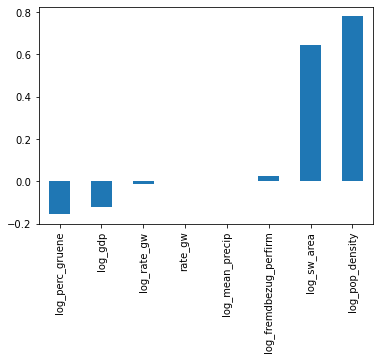

In [11]:
features = X.columns

X_train , X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 17)
lasso_cv = LassoCV(alphas = [0.0001, 0.001,0.01, 0.05,0.1, 1,5, 10], random_state=0).fit(X,y)

print(lasso_cv.score(X_train, y_train))
print(lasso_cv.score(X_test, y_test))

pd.Series(lasso_cv.coef_, features).sort_values(ascending = True).plot(kind= 'bar')

In [ ]:
just sw,pop denisity,perc gruene,gdp